## Initialization

> In this project an regression model for predicting the age of persons based on a photo should be developed.  
> Therefore a GPU platform is used, so that in this documentation only the training process is described and determined.  

> As basis for the training and evaluation a dataset wit 7.6k photos and the real ages of the persons is used.

## Imports and loading data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
df =pd.read_csv('/datasets/faces/labels.csv')
df.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## EDA

> In this step an overview over the data has been gained to identify possible issues or annomalies

### Age distribution

> Therefore in this step the age distribution has been investigated

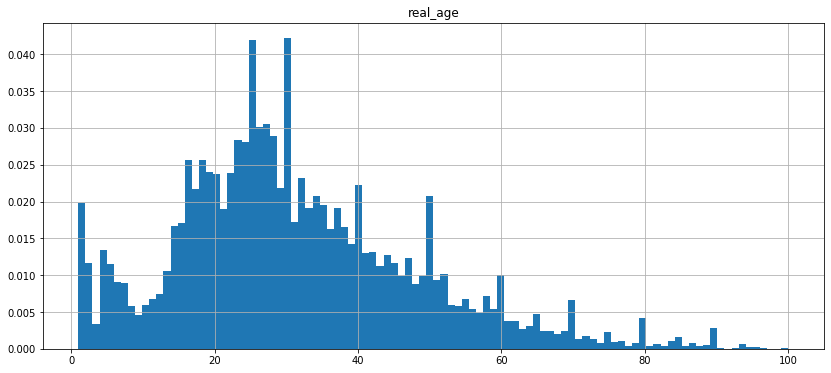

In [4]:
df.hist('real_age', 
        figsize=(14,6),
        bins=100,
        density=True
       );

> **Observations:**
> - There are two main age groups: 
>     - 0-7
>     - 14-50
> - Above 70 the amount of images is verry low, so that the model could face some difficulties to predict ages in that age range. It maybe makes sense to built the model for people up to 70 or 80 only
> - The round ages (Age % 10 == 0) have for most of the instances a significant higher numer of images than the ages in between

### Image Samples

> In this step a sample of 12 Images have been plotted to check for possible issues, or annomalies.  
> To prevent loading the whole dataset, a image Data generator has been used.

In [5]:
# Creating image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Specifying flow gen
gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


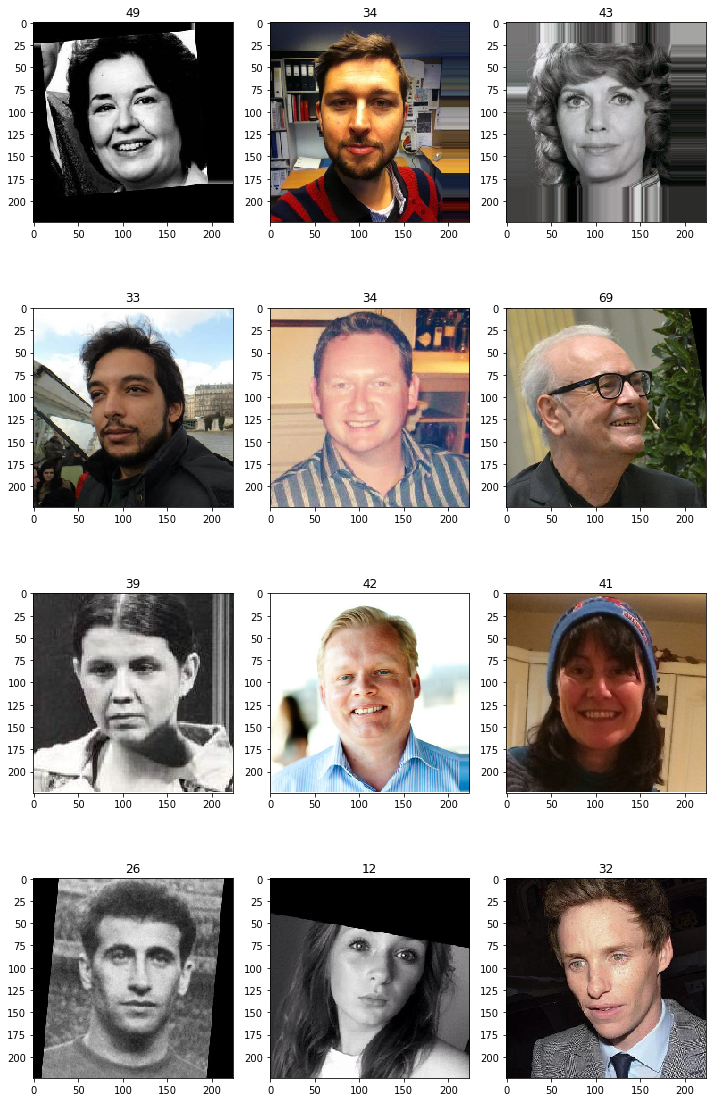

In [8]:
def show_batch(batch, predictions=None):
    """
        This function prints 12 Random samples of the dataframe including their label
    """
    fig = plt.figure(figsize=(10, 16))

    for i in range(12):
        fig.add_subplot(4, 3, i+1)
        plt.imshow(batch[0][i])
        title = batch[1][i]
        if predictions is not None:
            title = f'gt: {title}, pred: {round(predictions[i])}'
        plt.title(title)

    fig.tight_layout()

# Displaying 12 Samples
show_batch(next(gen_flow))

> **Observations:**
> - Different ethical backgrounds -> Imbalance maybe influences results
> - Different color schemes (b/w, rgb) 
> - Pictures are already cropped and rotated to only focus on head/face
> - The brightness/sharpness of the images differs -> Maybe use in imagedatagenerator as options

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    # Load df
    df = pd.read_csv(path + 'labels.csv')
    
    # Normalize val_range
    datagen = ImageDataGenerator(rescale=1./255,
                                zoom_range=0.05,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                shear_range=0.05,
                                horizontal_flip=True,
                                fill_mode="nearest",
                                validation_split=0.25)

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [1]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
        # Normalize val_range
    datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.25)
    
    df = pd.read_csv(path + 'labels.csv')
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [ ]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    optimizer = Adam(lr=0.0001)
    
    backbone_res = ResNet50(
        input_shape=input_shape, 
        weights='imagenet',
        include_top=False
    )
    
    model = Sequential()
    model.add(backbone_res)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

    return model


In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Prepare the Script to Run on the GPU Platform

> In this step the previous code snippets which are needed for the GPU plattform are patched together and written into a python file

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

The output below shows the model training process output by the GPU Plattform

Train for 356 steps, validate for 119 steps  
Epoch 1/20  
356/356 - 158s - loss: 210.2008 - mae: 10.5132 - val_loss: 627.7285 - val_mae: 19.9709  
Epoch 2/20  
356/356 - 90s - loss: 95.6631 - mae: 7.4615 - val_loss: 207.9024 - val_mae: 11.1328  
Epoch 3/20  
356/356 - 90s - loss: 68.6781 - mae: 6.3453 - val_loss: 101.8976 - val_mae: 7.7468  
Epoch 4/20  
356/356 - 90s - loss: 56.4964 - mae: 5.7713 - val_loss: 105.0671 - val_mae: 7.6447  
Epoch 5/20  
356/356 - 90s - loss: 45.9171 - mae: 5.1616 - val_loss: 76.1784 - val_mae: 6.5225  
Epoch 6/20  
356/356 - 90s - loss: 34.9831 - mae: 4.5833 - val_loss: 73.5379 - val_mae: 6.3924  
Epoch 7/20  
356/356 - 90s - loss: 30.1646 - mae: 4.2415 - val_loss: 74.6996 - val_mae: 6.3490  
Epoch 8/20  
356/356 - 90s - loss: 25.0257 - mae: 3.8803 - val_loss: 88.7650 - val_mae: 7.2373  
Epoch 9/20  
356/356 - 90s - loss: 22.4644 - mae: 3.6514 - val_loss: 81.0827 - val_mae: 6.9723  
Epoch 10/20  
356/356 - 90s - loss: 22.4197 - mae: 3.6139 - val_loss: 67.1543 - val_mae: 6.1096  
Epoch 11/20  
356/356 - 90s - loss: 18.8813 - mae: 3.3561 - val_loss: 74.7707 - val_mae: 6.2690  
Epoch 12/20  
356/356 - 90s - loss: 17.3686 - mae: 3.1994 - val_loss: 67.9631 - val_mae: 6.1087  
Epoch 13/20  
356/356 - 90s - loss: 16.1653 - mae: 3.0559 - val_loss: 69.6864 - val_mae: 6.1585  
Epoch 14/20  
356/356 - 90s - loss: 15.5416 - mae: 3.0248 - val_loss: 70.2373 - val_mae: 6.1985  
Epoch 15/20  
356/356 - 90s - loss: 15.1527 - mae: 2.9873 - val_loss: 68.7825 - val_mae: 6.1792  
Epoch 16/20  
356/356 - 90s - loss: 14.5465 - mae: 2.9300 - val_loss: 68.7151 - val_mae: 6.1847  
Epoch 17/20  
356/356 - 90s - loss: 15.1475 - mae: 2.9638 - val_loss: 73.0891 - val_mae: 6.3053  
Epoch 18/20  
356/356 - 90s - loss: 14.3714 - mae: 2.8663 - val_loss: 68.7878 - val_mae: 6.0513  
Epoch 19/20  
356/356 - 90s - loss: 12.7201 - mae: 2.7356 - val_loss: 65.0880 - val_mae: 6.0793  
Epoch 20/20  
356/356 - 90s - loss: 12.5251 - mae: 2.6652 - val_loss: 63.8020 - val_mae: 5.8732   
  
Testing  
119/119 - 10s - loss: 63.8020 - mae: 5.8732  
Test MAE: 5.8732  

> **Observations:**
> - The loss, mae, are continously decreasing whereas the vall_loss and val mae are decreasing overall with some local minima and maxima. 
> - The model shows a little tendency of overfitting due to the big difference between val loss and loss as well as mae and val_mae.

## Conclusions

> - The model performs quite good compared to the model performance reached in the paper of the dataset 
> - The model perfomance could be further improved by more complex structures, balancing of the data (uniform number of samples per age)
> - Dataset can be adjusted regarding ethical background and age derivation
> - Tendency of overfitting of the model could be minimized using structures like dropout layers and more simple architectures